# CSE 152: Intro to Computer Vision - Winter 2020 Assignment 4
## Instructor: David Kriegman
### Assignment published on Thursday, March 5, 2020
### Due on Wednesday, March 18, 2020 at 11:59pm

## Instructions
* This assignment must be completed individually. Review the academic integrity and collaboration policies on the course website.
* All solutions should be written in this notebook. Show your work for written questions.
* If you want to modify the skeleton code, you may do so. It has been merely been provided as a framework for your solution.
* You may use Python packages for basic linear algebra (e.g. NumPy or SciPy for basic operations), but you may not use packages that directly solve the problem. If you are unsure about using a specific package or function, ask the instructor and/or teaching assistants for clarification.
* You must submit this notebook exported as a PDF. You must also submit this notebook as an `.ipynb` file. Submit both files (`.pdf` and `.ipynb`) on Gradescope. **You must mark the PDF pages associated with each question in Gradescope. If you fail to do so, we may dock points.**
* It is highly recommended that you begin working on this assignment early.
* **Late policy:** a penalty of 10% per day after the due date.

---

## Problem 1: Machine Learning [15 pts]

In this problem, you will implement K-Nearest Neighbors (KNN) algorithm for computer vision problems.

### Part 1: Data preparation [1 pts]

Download the MNIST data from http://yann.lecun.com/exdb/mnist/.

Download the 4 zipped files, extract them into one folder, and change the variable 'path' in the code below. (Code taken from https://gist.github.com/akesling/5358964 )

Plot one random example image corresponding to each label from the training data.

In [1]:
import os
import struct
import numpy as np

# Change path as required
path = "./data/"

def read(dataset="training", datatype='images'):
    """
    Python function for importing the MNIST data set.  It returns an iterator
    of 2-tuples with the first element being the label and the second element
    being a numpy.uint8 2D array of pixel data for the given image.
    """

    if dataset is "training":
        fname_img = os.path.join(path, 'train-images.idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels.idx1-ubyte')
    elif dataset is "testing":
        fname_img = os.path.join(path, 't10k-images.idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels.idx1-ubyte')

    # Load everything in some numpy arrays
    with open(fname_lbl, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(fname_img, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows, cols)
    
    if(datatype=='images'):
        get_data = lambda idx: img[idx]
    elif(datatype=='labels'):
        get_data = lambda idx: lbl[idx]

    # Create an iterator which returns each image in turn
    for i in range(len(lbl)):
        yield get_data(i)
        
trainData=np.array(list(read('training','images')))
trainLabels=np.array(list(read('training','labels')))
testData=np.array(list(read('testing','images')))
testLabels=np.array(list(read('testing','labels')))

Some helper functions are given below.

Random classifier accuracy: 10.090000 

Plot random training images for each class:


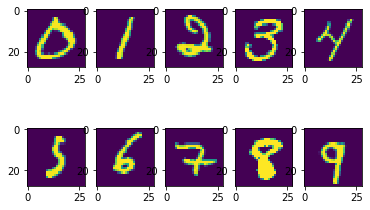

In [19]:
# a generator for batches of data
# yields data (batchsize, 3, 32, 32) and labels (batchsize)
# if shuffle, it will load batches in a random order
import matplotlib.pyplot as plt
def DataBatch(data, label, batchsize, shuffle=True):
    n = data.shape[0]
    if shuffle:
        index = np.random.permutation(n)
    else:
        index = np.arange(n)
    for i in range(int(np.ceil(n/batchsize))):
        inds = index[i*batchsize : min(n,(i+1)*batchsize)]
        yield data[inds], label[inds]

# tests the accuracy of a classifier
def test(testData, testLabels, classifier):
    batchsize=50
    correct=0.
    for data,label in DataBatch(testData,testLabels,batchsize,shuffle=False):
        prediction = classifier(data)
        correct += np.sum(prediction==label)
    return correct/testData.shape[0]*100

# a sample classifier
# given an input it outputs a random class
class RandomClassifier():
    def __init__(self, classes=10):
        self.classes=classes
    def __call__(self, x):
        return np.random.randint(self.classes, size=x.shape[0])

randomClassifier = RandomClassifier()
print('Random classifier accuracy: %f \n' % 
      test(testData, testLabels, randomClassifier))

print('Plot random training images for each class:')
count = 0
check = np.zeros(10)
imgs = np.zeros((10, 28, 28))
for img, lb in DataBatch(trainData, trainLabels, 1, shuffle=True):
    img = np.squeeze(img)
    if check[lb] == 1:
        continue
    else:
        check[lb] += 1
        count += 1
        imgs[lb,:,:] = img
    if count == 10:
        break

fig, ax = plt.subplots(nrows=2, ncols=5)
i = 0
for row in ax:
    for col in row:
        col.imshow(imgs[i,:,:])
        i += 1

plt.show()

### Part 2: Confusion Matrix [3 pts]
Here you will implement a function that computes the confusion matrix for a classifier.
The matrix (M) should be nxn where n is the number of classes.
Entry M[i,j] should contain the fraction of images of class i that were classified as class j.

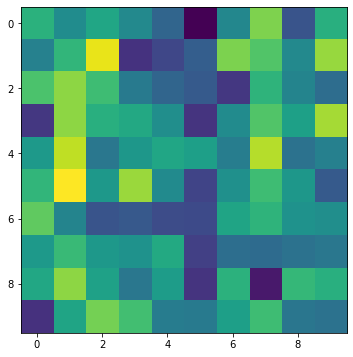

[[0.11 0.1  0.1  0.1  0.09 0.07 0.1  0.12 0.09 0.11]
 [0.1  0.11 0.12 0.08 0.08 0.09 0.12 0.11 0.1  0.12]
 [0.11 0.12 0.11 0.1  0.09 0.09 0.08 0.11 0.1  0.09]
 [0.08 0.12 0.11 0.1  0.1  0.08 0.1  0.11 0.1  0.12]
 [0.1  0.12 0.09 0.1  0.1  0.1  0.1  0.12 0.09 0.1 ]
 [0.11 0.13 0.1  0.12 0.1  0.08 0.1  0.11 0.1  0.09]
 [0.11 0.1  0.09 0.09 0.09 0.09 0.1  0.11 0.1  0.1 ]
 [0.1  0.11 0.1  0.1  0.11 0.08 0.09 0.09 0.09 0.09]
 [0.1  0.12 0.1  0.09 0.1  0.08 0.11 0.08 0.11 0.11]
 [0.08 0.1  0.11 0.11 0.1  0.09 0.1  0.11 0.09 0.09]]


In [3]:
# Using the tqdm module to visualize run time is suggested
from tqdm import tqdm
import time

# It would be a good idea to return the accuracy, along with the confusion 
# matrix, since both can be calculated in one iteration over test data, to 
# save time
def Confusion(testData, testLabels, classifier):
    '''
    Your code here
    '''
    
    prediction = classifier(testData)
    
    correct = np.sum(prediction == testLabels)
    
    accuracy = correct / len(prediction)
    
    M = np.zeros((10,10))
    
    for label, ground in zip(prediction, testLabels):
        M[label][ground] += 1
    
    M = M / np.sum(M, axis=1)

    return M, accuracy

def VisualizeConfusion(M):
    plt.figure(figsize=(14, 6))
    plt.imshow(M)
    plt.show()
    print(np.round(M,2))
    
M, _ = Confusion(testData, testLabels, randomClassifier)
VisualizeConfusion(M)

### Part 3: K-Nearest Neighbors (KNN) [6 pts]

* Here you will implement a simple knn classifier. The distance metric is Euclidean in pixel space. k refers to the number of neighbors involved in voting on the class, and should be 3. You are allowed to use sklearn.neighbors.KNeighborsClassifier.
* Display the confusion matrix and accuracy for your KNN classifier trained on the entire training dataset. (should be ~97%)
* After evaluating the classifier on the test set, based on the confusion matrix, mention the number that the number '7' is most often predicted to be, other than '7'. Write your comment below.

In [4]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import matplotlib.pyplot as plt
class KNNClassifer():
    def __init__(self, k=3):
        # k is the number of neighbors involved in voting
        '''
        your code here
        '''
        self.classifier = KNeighborsClassifier(n_neighbors=k)

    def train(self, trainData, trainLabels):
        '''
        your code here
        '''
        self.classifier.fit(trainData.reshape((trainData.shape[0], 784)), trainLabels)
        
    def __call__(self, x):
        # this method should take a batch of images
        # and return a batch of predictions
        '''
        your code here
        '''
        return self.classifier.predict(x.reshape((x.shape[0], 784)))

# test your classifier with only the first 100 training examples (use this
# while debugging)
# note you should get ~ 65 % accuracy
knnClassiferX = KNNClassifer()
knnClassiferX.train(trainData[:100], trainLabels[:100])
print ('KNN classifier accuracy: %f'%test(testData, testLabels, knnClassiferX))

KNN classifier accuracy: 64.760000


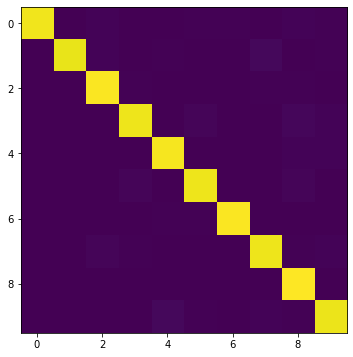

[[0.97 0.   0.01 0.   0.   0.01 0.01 0.   0.01 0.  ]
 [0.   0.96 0.01 0.   0.01 0.   0.   0.02 0.   0.  ]
 [0.   0.   0.98 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.96 0.   0.01 0.   0.   0.02 0.01]
 [0.   0.   0.   0.   0.98 0.   0.   0.   0.01 0.01]
 [0.   0.   0.   0.01 0.   0.97 0.   0.   0.01 0.  ]
 [0.   0.   0.   0.   0.   0.01 0.98 0.   0.   0.  ]
 [0.   0.   0.01 0.01 0.   0.   0.   0.96 0.   0.01]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.  ]
 [0.   0.   0.   0.   0.02 0.   0.   0.01 0.   0.96]]
KNN classifier training acc: 0.970400


In [5]:
# test your classifier trained with all the training examples (This may take a while)
knnClassifer = KNNClassifer()
knnClassifer.train(trainData[:-1], trainLabels[:-1])

# display confusion matrix and testing accuracy for your KNN classifier trained with all the training examples
M, acc = Confusion(testData, testLabels, knnClassifer)
VisualizeConfusion(M)
print('KNN classifier training acc: %f'%acc)

### Comment:
Ans: 9

#### 3.1 : Testing performance with different number of Neighbors
Plot the overall accuracy of the classifier for k = [1,3,5,7,15]. Comment on your results. Choose the value of k that you feel is the best and use this value for the next question.

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [51:03<00:00, 612.78s/it]


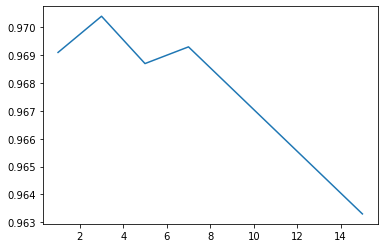

In [6]:
'''
Your code to plot the accuracy 
for a variable number of nearest neighbours.
'''
tempList = []
ks = [1,3,5,7,15]
for i in tqdm(ks):
    knnClassifier = KNNClassifer(i)
    knnClassifier.train(trainData[:-1], trainLabels[:-1])
    _, acc = Confusion(testData, testLabels, knnClassifier)
    tempList.append(acc)

plt.plot(ks,tempList)

### Part 4: Principal Component Analysis (PCA) K-Nearest Neighbors (KNN) [5 pts]
Here you will implement a simple KNN classifer in PCA space (for k= the value you found best, and a variable number of principal components).
You are allowed to use sklearn.decomposition.PCA or any other package that directly implements PCA transformations. For more information refer https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

Is the testing time for PCA KNN classifier more or less than that for KNN classifier? Comment on why it differs if it does.

Ans: yes it is faster to run pca knn, it differs because PCA reduces the amount of data, which allows for faster runtimes.

In [7]:
from sklearn.decomposition import PCA
class PCAKNNClassifer():
    def __init__(self, components=25, k= 3):
        # components = number of principal components
        # k is the number of neighbors involved in voting
        """ ==========
        YOUR CODE HERE
        ========== """
        self.pca = PCA(components)
        self.knn = KNeighborsClassifier(k)
        
    def train(self, trainData, trainLabels):
        """ ==========
        YOUR CODE HERE
        ========== """
        '''
        For optimal results make sure your training data has 0 mean
        by computing the mean of the training vectors and subtracting 
        the mean vector from each of the samples. (Very similar to the procedure
        you followed in the template matching problem. (HW1 Q 3.3))
        '''
        trainData = trainData.reshape((trainData.shape[0], -1))
        self.mean = np.mean(trainData, axis=0)
        trainData = trainData - self.mean
        
        
        self.pca = self.pca.fit(trainData)
        
        
        trainData = self.pca.transform(X=trainData)
        
        self.knn.fit(trainData, trainLabels)
        
    def __call__(self, x):
        # this method should take a batch of images
        # and return a batch of predictions
        """ ==========
        YOUR CODE HERE
        ========== """
        '''
        If you have centered your training data by subtracting the mean
        make sure you subtract the same mean from your test data as well.
        '''
        x = x.reshape((x.shape[0], 784)) - self.mean
        x = self.pca.transform(x)
        
        return self.knn.predict(x)
        



# test your classifier with only the first 100 training examples (use this
# while debugging)
pcaknnClassiferX = PCAKNNClassifer()
pcaknnClassiferX.train(trainData[:100], trainLabels[:100])
print ('KNN classifier accuracy: %f'%test(testData, testLabels, pcaknnClassiferX))

KNN classifier accuracy: 66.130000


In [8]:
# test your classifier with all the training examples
pcaknnClassifer = PCAKNNClassifer()
pcaknnClassifer.train(trainData, trainLabels)

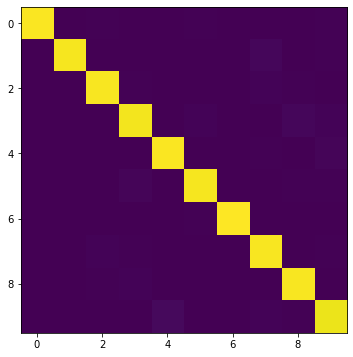

[[0.98 0.   0.   0.   0.   0.01 0.   0.   0.   0.  ]
 [0.   0.97 0.   0.   0.   0.   0.   0.02 0.   0.01]
 [0.   0.   0.97 0.   0.   0.   0.   0.01 0.   0.  ]
 [0.   0.   0.   0.97 0.   0.01 0.   0.   0.02 0.01]
 [0.   0.   0.   0.   0.98 0.   0.   0.   0.   0.01]
 [0.   0.   0.   0.01 0.   0.97 0.   0.   0.01 0.  ]
 [0.   0.   0.   0.   0.   0.01 0.98 0.   0.   0.  ]
 [0.   0.   0.01 0.01 0.   0.   0.   0.97 0.   0.  ]
 [0.   0.   0.   0.01 0.   0.   0.   0.   0.98 0.  ]
 [0.   0.   0.   0.   0.03 0.   0.   0.01 0.   0.96]]
pcaknn acc: 0.973200


In [9]:
# display confusion matrix for your PCA KNN classifier with all the training examples
""" ==========
YOUR CODE HERE
========== """
M, acc = Confusion(testData, testLabels, pcaknnClassifer)
VisualizeConfusion(M)
print('pcaknn acc: %f' %acc)

#### 4.1 : Testing performance with different number of PCA components.
Plot the overall classification accuracy and display the confusion matrix for k = value chosen by you, and principal components = [1 , 10 , 25, 50]. For Principal components = 25, output the sensitivity and specificity of the classifier for digit 0. (Please look up the terms sensitivity and specificity for details on their formulas.) Comment on your results for sensitivity and specificity by mentioning the meaning of these terms. Suppose the classifier is used to detect 0's but it turns out that processing 0's is very expensive and hence a digit should be classified as 0 only if we are very sure. Which term (sensitivity or specificity) should we focus on optimizing?  
Reference : https://en.wikipedia.org/wiki/Sensitivity_and_specificity


pcaknn components=1 k=3:
acc: 0.269500


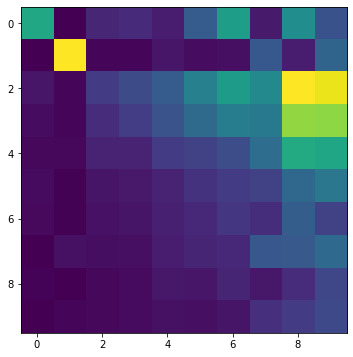

[[0.45 0.   0.08 0.09 0.06 0.22 0.42 0.06 0.37 0.19]
 [0.   0.75 0.01 0.01 0.05 0.03 0.03 0.21 0.06 0.24]
 [0.05 0.01 0.13 0.17 0.22 0.32 0.41 0.35 0.75 0.72]
 [0.03 0.01 0.09 0.14 0.19 0.26 0.31 0.3  0.63 0.62]
 [0.02 0.02 0.07 0.07 0.13 0.14 0.18 0.27 0.46 0.44]
 [0.02 0.01 0.04 0.05 0.07 0.11 0.13 0.14 0.25 0.29]
 [0.02 0.   0.04 0.04 0.07 0.08 0.12 0.1  0.22 0.14]
 [0.   0.03 0.03 0.03 0.06 0.08 0.09 0.2  0.21 0.26]
 [0.01 0.   0.01 0.02 0.05 0.05 0.08 0.05 0.09 0.16]
 [0.   0.01 0.02 0.02 0.03 0.03 0.04 0.1  0.13 0.16]]
pcaknn components=10 k=3:
acc: 0.924500


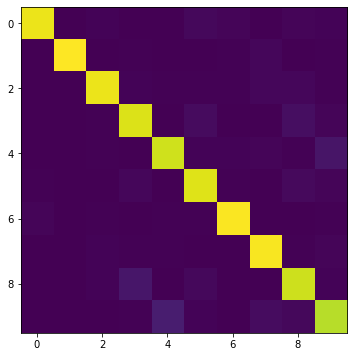

[[0.94 0.   0.01 0.   0.   0.02 0.01 0.   0.01 0.01]
 [0.   0.97 0.   0.01 0.   0.   0.01 0.02 0.   0.01]
 [0.   0.   0.94 0.01 0.   0.01 0.01 0.02 0.02 0.  ]
 [0.   0.   0.   0.92 0.   0.03 0.   0.   0.03 0.01]
 [0.   0.   0.   0.   0.9  0.01 0.01 0.01 0.01 0.06]
 [0.   0.   0.   0.02 0.   0.92 0.01 0.   0.03 0.01]
 [0.01 0.   0.01 0.   0.01 0.   0.96 0.   0.   0.  ]
 [0.   0.   0.01 0.01 0.01 0.   0.   0.96 0.   0.01]
 [0.   0.   0.01 0.06 0.   0.02 0.   0.   0.89 0.01]
 [0.   0.   0.   0.01 0.08 0.01 0.   0.03 0.02 0.86]]
pcaknn components=25 k=3:
sensitivity of 0: 0.979859
specificity of 0: 0.972085
acc: 0.973200


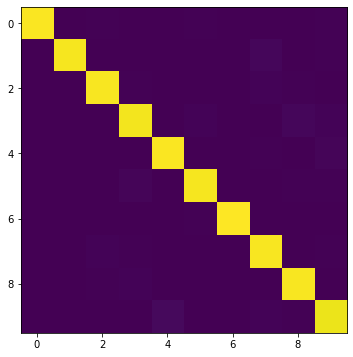

[[0.98 0.   0.   0.   0.   0.01 0.   0.   0.   0.  ]
 [0.   0.97 0.   0.   0.   0.   0.   0.02 0.   0.01]
 [0.   0.   0.97 0.   0.   0.   0.   0.01 0.   0.  ]
 [0.   0.   0.   0.97 0.   0.01 0.   0.   0.02 0.01]
 [0.   0.   0.   0.   0.98 0.   0.   0.   0.   0.01]
 [0.   0.   0.   0.01 0.   0.97 0.   0.   0.01 0.  ]
 [0.   0.   0.   0.   0.   0.01 0.98 0.   0.   0.  ]
 [0.   0.   0.01 0.01 0.   0.   0.   0.97 0.   0.  ]
 [0.   0.   0.   0.01 0.   0.   0.   0.   0.98 0.  ]
 [0.   0.   0.   0.   0.03 0.   0.   0.01 0.   0.96]]
pcaknn components=50 k=3:
acc: 0.975100


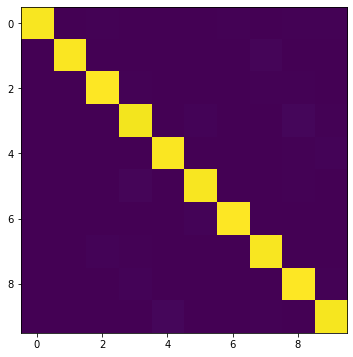

[[0.97 0.   0.   0.   0.   0.   0.01 0.   0.01 0.01]
 [0.   0.98 0.   0.   0.   0.   0.   0.01 0.   0.  ]
 [0.   0.   0.98 0.   0.   0.   0.   0.01 0.   0.  ]
 [0.   0.   0.   0.97 0.   0.01 0.   0.   0.02 0.01]
 [0.   0.   0.   0.   0.98 0.   0.   0.   0.01 0.01]
 [0.   0.   0.   0.01 0.   0.97 0.   0.   0.01 0.  ]
 [0.   0.   0.   0.   0.   0.01 0.98 0.   0.   0.  ]
 [0.   0.   0.01 0.01 0.   0.   0.   0.97 0.   0.  ]
 [0.   0.   0.   0.01 0.   0.   0.   0.   0.98 0.  ]
 [0.   0.   0.   0.   0.02 0.   0.   0.01 0.   0.97]]


In [10]:
'''
Your code here for the variable number of principal components
and plotting the confusion matrix, and overall accuracy.
MAKE SURE ALL YOUR PLOTS HAVE TITLES AND/OR MARKDOWN CELLS CLEARLY
INDICATING WHAT EACH FIGURE CORRESPONDS TO.
'''
numOfCompnnts = [1,10,25,50]
for i in (numOfCompnnts):
    pcaknnClassifer = PCAKNNClassifer(i)
    pcaknnClassifer.train(trainData, trainLabels)
    M, acc = Confusion(testData, testLabels, pcaknnClassifer)
    print('pcaknn components=%i k=3:'%i)
    if i == 25:
        print('sensitivity of 0: %f'%M[0][0])
        spec = np.trace(M) - M[0][0]
        spec = spec / np.sum(M[1:])
        print('specificity of 0: %f'%spec)
    print('acc: %f'%acc)
    VisualizeConfusion(M)

#### Comments:
zero's true positive rate(sensitivity) is 97.9%, and the true negative(specificity) is 97.2%.
focus on sensitivity.

## Problem 2: Deep Learning [25 pts]

### Part 1: Initial setup [0 pts]

Follow the directions on https://pytorch.org/get-started/locally/ to install PyTorch on your computer.

Note: You will not need GPU support for this assignment so don't worry if you don't have one. In any case, installing with GPU support is often more difficult to configure, so it is suggested that you install the CPU-only version regardless.

To ensure that PyTorch was installed correctly, we will now verify the installation by running some sample PyTorch code. Here we construct a randomly initialized tensor.

In [11]:
from __future__ import print_function
import torch
x = torch.rand(5, 3)
print(x)

tensor([[0.0027, 0.3587, 0.1789],
        [0.8333, 0.2350, 0.6553],
        [0.2700, 0.1213, 0.1568],
        [0.8825, 0.0692, 0.0302],
        [0.1229, 0.5016, 0.9283]])


### Part 2:  Training with PyTorch [3 pts]
Below is some helper code to train your deep networks. 
Complete the train function for PTClassifier below. You should write down the training operations in this function. This function will be used in the following questions with different networks.
You can look at https://pytorch.org/tutorials/beginner/pytorch_with_examples.html for reference.

In [12]:
# base class for your PyTorch networks. It implements the training loop
# (__init__), (train) and prediction(__call__)  for you.
# You will need to complete the (train) function to define the training operations
# structures in the following problems.
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.nn.init
import torch.optim as optim
from torch.autograd import Variable
from tqdm import tqdm
from scipy.stats import truncnorm

class PTClassifier():
    def __init__(self, net):
        self.net = net()
    
    def train(self, trainData, trainLabels, testData, testLabels, epochs=1, batchsize=50):
        criterion = nn.CrossEntropyLoss()
        learning_rate=3e-4
        optimizer = optim.Adam(self.net.parameters(),lr=learning_rate)
        for epoch in range(epochs):
            for i, (data,label) in enumerate(DataBatch(trainData, trainLabels, batchsize, shuffle=True)):
                inputs = Variable(torch.FloatTensor(data))
                targets = Variable(torch.LongTensor(label))

                predictions = self.net(inputs)
                loss = criterion(predictions, targets)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                # YOUR CODE HERE
                # Train the model using the optimizer and the batch data

                
            print ('Epoch:%d Accuracy: %f'%(epoch+1, test(testData, testLabels, self)))
    
    def __call__(self, x):
        inputs = Variable(torch.FloatTensor(x))
        prediction = self.net(inputs)
        return np.argmax(prediction.data.cpu().numpy(), 1)
    
    def get_first_layer_weights(self):
        return self.net.weight1.data.cpu().numpy()

# helper function to get weight variable
def weight_variable(shape):
    initial = torch.Tensor(truncnorm.rvs(-1/0.01, 1/0.01, scale=0.01, size=shape))
    return Parameter(initial, requires_grad=True)

# helper function to get bias variable
def bias_variable(shape):
    initial = torch.Tensor(np.ones(shape)*0.1)
    return Parameter(initial, requires_grad=True)
    
# Define Single Layer Perceptron network
class SLP(nn.Module):
    def __init__(self, in_features=28*28, classes=10):
        super(SLP, self).__init__()
        # model variables
        self.weight1 = weight_variable((classes, in_features))
        self.bias1 = bias_variable((classes))
        
    def forward(self, x):
        # linear operation
        y_pred = torch.addmm(self.bias1, x.view(list(x.size())[0], -1), self.weight1.t())
        return y_pred
        

# test the example linear classifier (note you should get around 92% accuracy
# for 10 epochs and batchsize 50)
trainData=np.array(list(read('training','images')))
trainData=np.float32(np.expand_dims(trainData,-1))/255
trainData=trainData.transpose((0,3,1,2))
trainLabels=np.int32(np.array(list(read('training','labels'))))

testData=np.array(list(read('testing','images')))
testData=np.float32(np.expand_dims(testData,-1))/255
testData=testData.transpose((0,3,1,2))
testLabels=np.int32(np.array(list(read('testing','labels'))))

linearClassifier = PTClassifier(SLP)
linearClassifier.train(trainData, trainLabels, testData, testLabels, epochs=10)
print ('Linear classifier accuracy: %f'%test(testData, testLabels, linearClassifier))

Epoch:1 Accuracy: 89.020000
Epoch:2 Accuracy: 90.760000
Epoch:3 Accuracy: 91.360000
Epoch:4 Accuracy: 91.560000
Epoch:5 Accuracy: 91.850000
Epoch:6 Accuracy: 92.090000
Epoch:7 Accuracy: 92.200000
Epoch:8 Accuracy: 92.230000
Epoch:9 Accuracy: 92.410000
Epoch:10 Accuracy: 92.360000
Linear classifier accuracy: 92.360000


### Part 3: Single Layer Perceptron [3 pts]
The simple linear classifier implemented in the cell already performs quite well. Plot the filter weights corresponding to each output class (weights, not biases) as images. (Normalize weights to lie between 0 and 1 and use color maps like 'inferno' or 'plasma' for good results). Comment on what the weights look like and why that may be so.


(10, 784)
showing class 0:


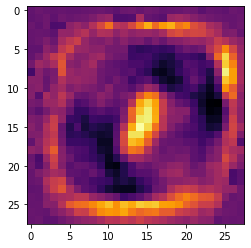

showing class 1:


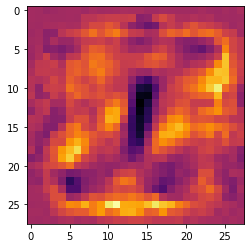

showing class 2:


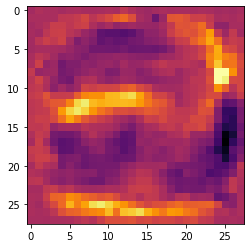

showing class 3:


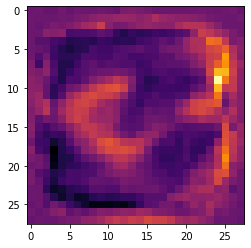

showing class 4:


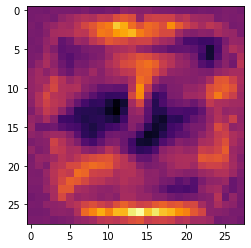

showing class 5:


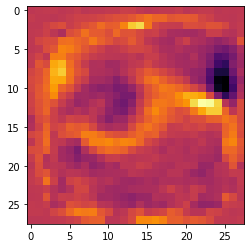

showing class 6:


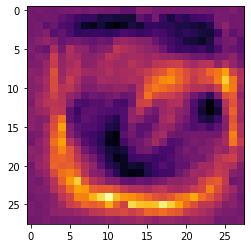

showing class 7:


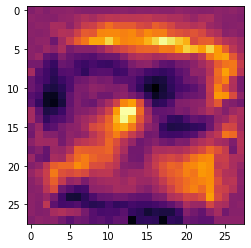

showing class 8:


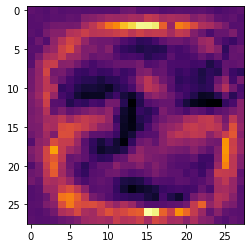

showing class 9:


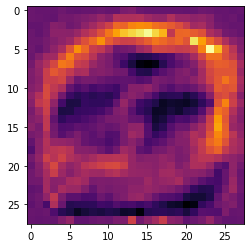

In [13]:
# Your code here.
print(linearClassifier.net.weight1.detach().numpy().shape)
theInput = linearClassifier.net.weight1.detach().numpy().reshape((10,28,28)) / np.sum(linearClassifier.net.weight1.detach().numpy())
for i in range(10):
    print('showing class %i:'%i)
    plt.imshow(theInput[i], cmap='inferno')
    plt.show()




### Comment
the weights look like they somewhat resemle the labels they are representing. this is probably because it is using those areas as indications for deciding on a particular number.

### Part 4: Multi Layer Perceptron (MLP) [7 pts]
Here you will implement an MLP. The MLP shoud consist of 2 layers (matrix multiplication and bias offset) that map to the following feature dimensions:

* 28x28 -> hidden (100)
* hidden -> classes

* The hidden layer should be followed with a ReLU nonlinearity. The final layer should not have a nonlinearity applied as we desire the raw logits output.
* The final output of the computation graph should be stored in self.y as that will be used in the training.

Display the confusion matrix and accuracy after training. Note: You should get around 97% accuracy for 10 epochs and batch size 50.

Plot the filter weights corresponding to the mapping from the inputs to the first 10 hidden layer outputs (out of 100). Do the weights look similar to the weights plotted in the previous problem? Why or why not?

In [14]:
# Define Multi Layer Perceptron network
class MLP(nn.Module):
    def __init__(self, in_features=28*28, hidden=100, classes=10):
        super(MLP, self).__init__()
        '''
        your code here
        '''
        self.fc1 = torch.nn.Sequential(
            nn.Linear(in_features, hidden),
            nn.ReLU()
        )
        self.weight1 = self.fc1[0].weight
        self.fc2 = nn.Linear(hidden, classes)
        
    def forward(self, x):
        '''
        your code here
        '''
        x = x.view(list(x.size())[0], -1)
        hidden = self.fc1(x)
        self.y = self.fc2(hidden)
        return self.y

mlpClassifer = PTClassifier(MLP)
mlpClassifer.train(trainData, trainLabels, testData, testLabels, epochs=10)

Epoch:1 Accuracy: 92.000000
Epoch:2 Accuracy: 93.610000
Epoch:3 Accuracy: 94.730000
Epoch:4 Accuracy: 95.280000
Epoch:5 Accuracy: 95.950000
Epoch:6 Accuracy: 96.300000
Epoch:7 Accuracy: 96.490000
Epoch:8 Accuracy: 96.910000
Epoch:9 Accuracy: 96.810000
Epoch:10 Accuracy: 97.140000


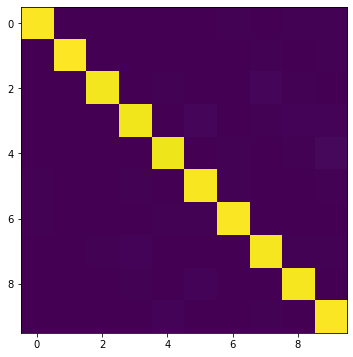

[[0.98 0.   0.   0.   0.   0.   0.01 0.   0.   0.01]
 [0.   0.98 0.   0.   0.   0.   0.   0.   0.   0.01]
 [0.   0.   0.96 0.   0.01 0.   0.   0.01 0.01 0.  ]
 [0.   0.   0.   0.96 0.   0.02 0.   0.   0.01 0.01]
 [0.   0.   0.   0.   0.96 0.   0.01 0.   0.01 0.02]
 [0.   0.   0.   0.   0.   0.97 0.01 0.   0.   0.  ]
 [0.01 0.   0.   0.   0.   0.01 0.98 0.   0.   0.  ]
 [0.   0.   0.01 0.01 0.   0.   0.   0.97 0.01 0.01]
 [0.   0.   0.   0.   0.   0.01 0.   0.   0.97 0.  ]
 [0.   0.   0.   0.   0.01 0.   0.   0.   0.   0.98]]
nn acc: 0.971400


In [15]:
# Confusion Matrix and Accuracy
'''
your code here
'''
M, acc = Confusion(testData, testLabels, mlpClassifer)
VisualizeConfusion(M)
print('nn acc: %f' %acc)

(100, 784)


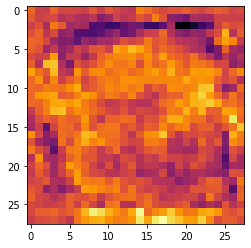

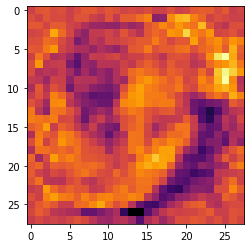

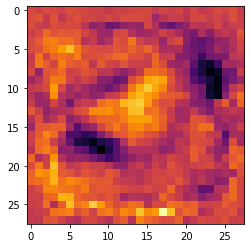

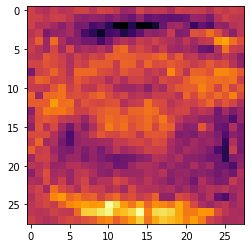

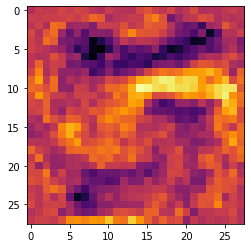

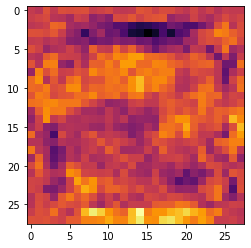

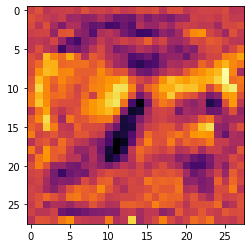

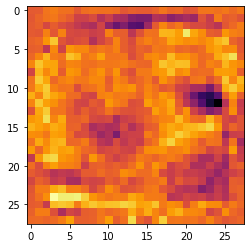

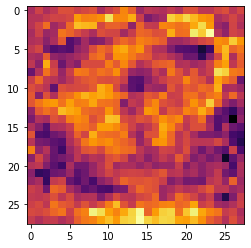

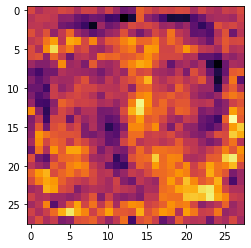

In [16]:
# plot filter weights
'''
your code here
'''
print(mlpClassifer.get_first_layer_weights().shape)
images = mlpClassifer.get_first_layer_weights().reshape((100,28,28))

for i in range(10):
    plt.imshow(images[i], cmap='inferno')
    plt.show()


### Comment
they do not look too similar, probably because the representations in the hidden layer do not necessarily look for specific classes.

### Part 5: Convolutional Neural Network (CNN) [12 pts]
Here we will implement the classic LeNET network with the following architecture:

* a convolutional layer connecting the input image to 6 feature maps with 5 × 5 convolutions and followed by ReLU and maxpooling,
* a convolutional layer connecting the 6 input channels to 16 output channels with 5 × 5 convolutions and followed by ReLU and maxpooling
* a fully-connected layer connecting 16 feature maps to 120 output units and followed by ReLU,
* a fully-connected layer connecting 120 inputs to 84 output units and followed by ReLU,
* a final linear layer connecting 84 inputs to 10 linear outputs (one for each of our digits).

Display the confusion matrix and accuracy after training. You should get around 98% accuracy for 10 epochs and batch size 100.

** START EARLY. RUNNING THIS CODE WILL TAKE ABOUT AN HOUR **

In [17]:
def conv2d(x, W, stride):
    # x: input
    # W: weights (out, in, kH, kW)
    return F.conv2d(x, W, stride=stride, padding=1)

# Define Convolutional Neural Network
class LeNet(nn.Module):
    def __init__(self, in_features=28*28, n_classes=10):
        super(LeNet, self).__init__()
        '''
        your code here
        '''
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=1, bias=True),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=1, bias=True),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(400, 120, bias=True),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(120, 84, bias=True),
            nn.ReLU()
        )
        self.final = nn.Sequential(
            nn.Linear(84, 10, bias=True)
        )
        
    def forward(self, x):
        '''
        your code here
        '''
        cv1 = self.conv1(x)
        cv2 = self.conv2(cv1)
        cv2 = cv2.view(list(cv2.size())[0], -1)
        fcl1 = self.fc1(cv2)
        fcl2 = self.fc2(fcl1)
        self.y = self.final(fcl2)
        return self.y
        
    #Determine the number of features in a batch of tensors
    def num_flat_features(self, x):
        size = x.size()[1:]
        return np.prod(size)

cnnClassifer = PTClassifier(LeNet)
cnnClassifer.train(trainData, trainLabels, testData, testLabels, epochs=10)

Epoch:1 Accuracy: 95.370000
Epoch:2 Accuracy: 97.290000
Epoch:3 Accuracy: 97.900000
Epoch:4 Accuracy: 97.840000
Epoch:5 Accuracy: 98.040000
Epoch:6 Accuracy: 98.570000
Epoch:7 Accuracy: 98.260000
Epoch:8 Accuracy: 98.820000
Epoch:9 Accuracy: 98.760000
Epoch:10 Accuracy: 98.770000


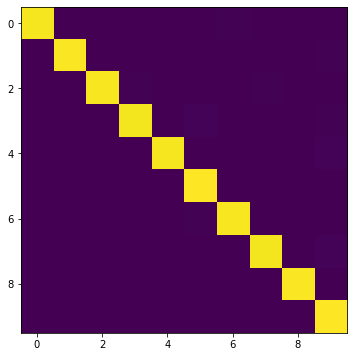

[[0.98 0.   0.   0.   0.   0.   0.01 0.   0.   0.  ]
 [0.   0.99 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.99 0.   0.   0.   0.   0.01 0.   0.  ]
 [0.   0.   0.   0.98 0.   0.01 0.   0.   0.   0.01]
 [0.   0.   0.   0.   0.98 0.   0.   0.   0.   0.01]
 [0.   0.   0.   0.   0.   0.99 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.99 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.98 0.   0.01]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   1.  ]]
cnn acc: 0.987700


In [18]:
# Confusion Matrix and Accuracy
'''
your code here
'''
M, acc = Confusion(testData, testLabels, cnnClassifer)
VisualizeConfusion(M)
print('cnn acc: %f' %acc)

* Note that the MLP/ConvNet approaches lead to an accuracy a little higher than the K-NN approach. 
* In general, neural net approaches lead to a significant increase in accuracy, but in this case the problem is not too hard, so the increase in accuracy will not be very high.
* However, this is still quite significant considering the fact that the ConvNets we've used are relatively simple while the accuracy achieved using K-NN is with a search over 60,000 training images for every test image.
* You can look at the performance of various machine learning methods on this problem at http://yann.lecun.com/exdb/mnist/
* You can learn more about PyTorch at https://pytorch.org/tutorials/index.html
* You can find another image classifier training example at https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py
* You can play with a demo of neural network created by Daniel Smilkov and Shan Carter at https://playground.tensorflow.org/